In [1]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts

from analysis import *
from process import *
from plots import *

with open('config.json') as f:
    config = json.load(f)

In [2]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## Get session and probe

In [3]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [4]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
print(json.dumps(info, indent=4))

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772
}


## Get units in area of interest

In [5]:
# units in a session after quality filter
units = session.units
sel_units = units[units['ecephys_structure_acronym'] == ecephys_structure_acronym]
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


## Analyze spikes

### Get drifting gratings stimulus information

In [6]:
stimulus_name = 'drifting_gratings'
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

bin_width = 0.03
units_fr = get_units_firing_rate(session, grating_ids, sel_units_id, condition_id, cond_presentation_id,
                                 bin_width=bin_width, window=(-0.5, grating_duration))

### Preprocess units firing rate

In [7]:
sigma = 0.02 # sec
quantile = 0.2
soft_normalize_cut = np.quantile(units_fr.units_mean_fr, quantile)
units_fr = preprocess_firing_rate(units_fr, sigma, soft_normalize_cut)

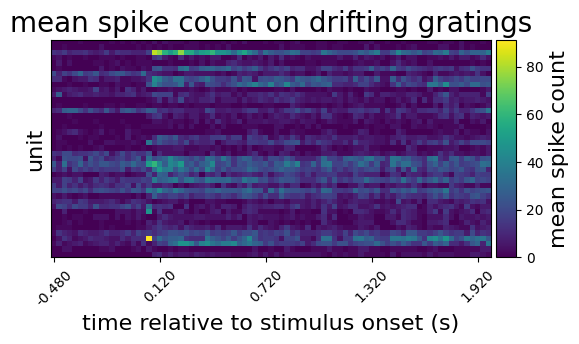

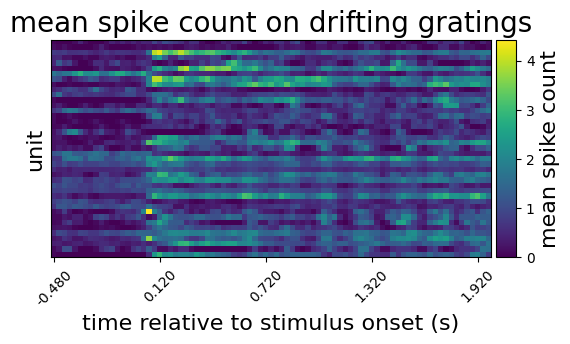

In [8]:
# Example condition activity
cond_id = condition_id[0, 0]
units_fr0 = units_fr.spike_rate.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)

units_fr0 = units_fr.normalized.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)
plt.show()

### PCA analysis

Explained variance % of top 10 components: 
21.61, 15.33, 14.51, 7.64, 5.40, 4.67, 2.81, 2.48, 2.06, 1.77


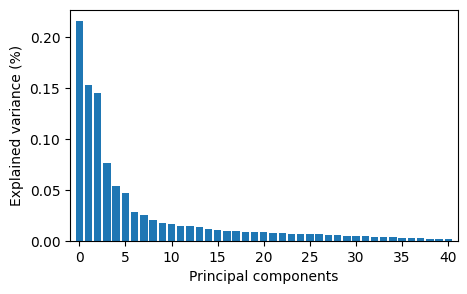

In [23]:
from sklearn.decomposition import PCA

units_vec = units_fr.normalized.stack(sample=['condition_id', 'time_relative_to_stimulus_onset']).T

n_units = units_vec.unit_id.size
n_components = n_units
pca = PCA(n_components=n_components)
pca.fit(units_vec)
pop_vec = pca.transform(units_vec)
pop_vec = units_vec.copy(data=pop_vec).rename(unit_id='PC').unstack('sample')
pop_vec.coords['PC'] = range(n_components)
pop_vec = pop_vec.assign_attrs(bin_width=units_fr.bin_width)

print('Explained variance % of top 10 components: \n' + 
      ', '.join('%.2f' % (100 * x) for x in pca.explained_variance_ratio_[:10]))
plt.figure(figsize=(5, 3))
plt.bar(np.arange(n_components), pca.explained_variance_ratio_)
plt.xlim(-1, n_components)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.show()

In [10]:
pop_vec_cond = pop_vec.sel(condition_id=condition_id)
n_orient = pop_vec_cond.orientation.size
n_tfreq = pop_vec_cond.temporal_frequency.size

cmap1 = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
cmap2 = plt.cm.get_cmap('jet')(np.arange(n_tfreq) / n_tfreq)[:, :3]

Time interval: (-30.0, 330.0) ms


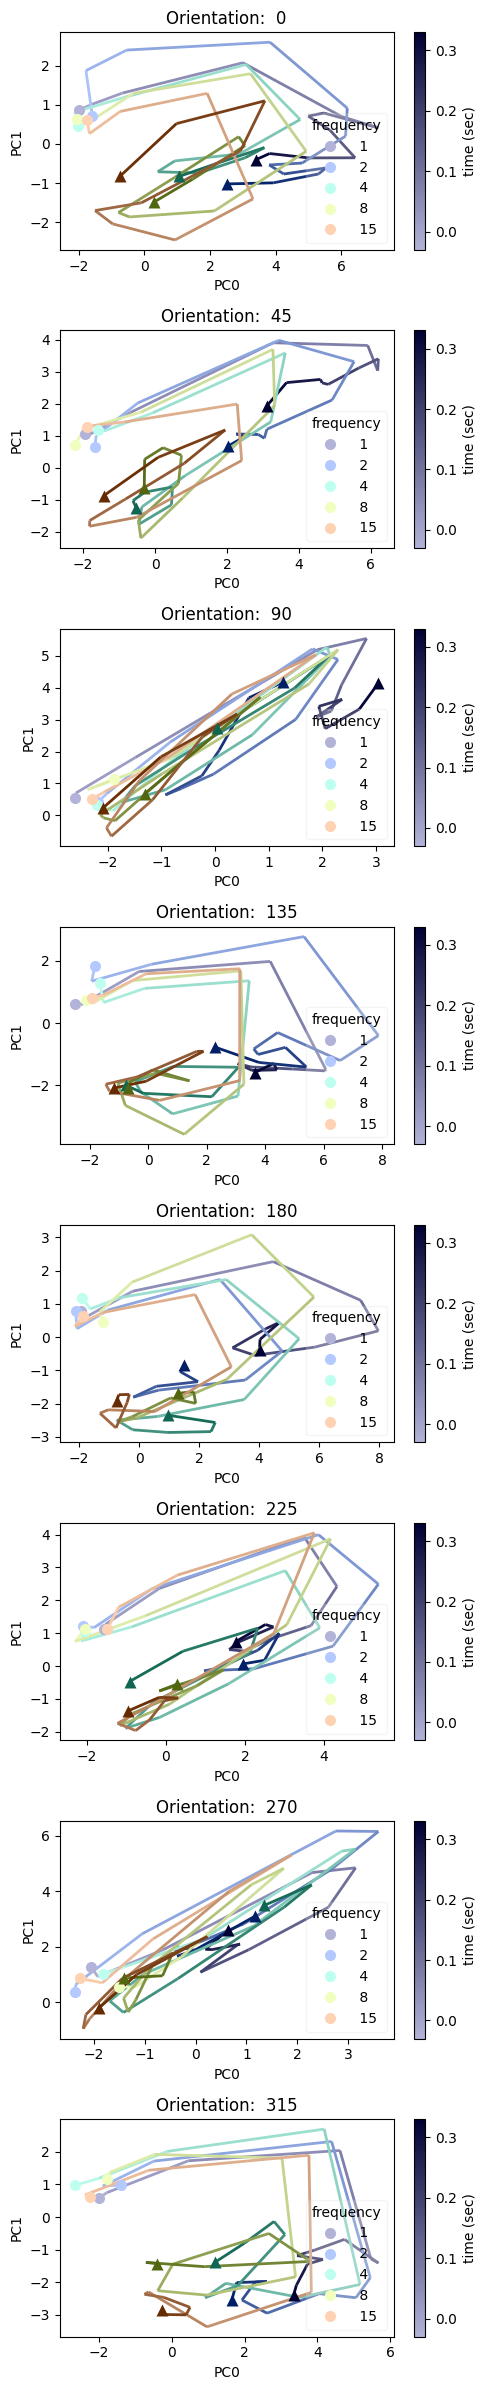

In [11]:
PC_axis = [0, 1]
pop_vec_cond_pc = pop_vec_cond.sel(PC=PC_axis, time_relative_to_stimulus_onset=slice(-0.05, 0.33))
_, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
axs = axs.ravel()
t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values
for i, orient in enumerate(pop_vec_cond.orientation):
    ax = axs[i]
    for j, tfreq in enumerate(pop_vec_cond.temporal_frequency):
        lighten_cmap = get_lighten_cmap(cmap2[j], light_scale=0.7, dark_scale=0.6)
        pop_vec_tfreq = pop_vec_cond_pc.sel(orientation=orient, temporal_frequency=tfreq)
        line = plot_multicolor_line(*pop_vec_tfreq, c=t, ax=ax, cmap=lighten_cmap, linewidth=2)
        ax.plot(*pop_vec_tfreq[:, 0], linestyle='none', marker='o',
                markersize=8, markeredgecolor='none', markerfacecolor=lighten_cmap(0.), label=f'{tfreq: .0f}')
        ax.plot(*pop_vec_tfreq[:, -1], linestyle='none', marker='^',
                markersize=8, markeredgecolor='none', markerfacecolor=lighten_cmap(1.))
        if not j:
            plt.colorbar(mappable=line, ax=ax, label='time (sec)')
    ax.set_xlabel(f'PC{PC_axis[0]:d}')
    ax.set_ylabel(f'PC{PC_axis[1]:d}')
    ax.legend(loc='lower right', title='frequency', framealpha=0.2)
    ax.set_title(f'Orientation: {orient: .0f}')
plt.tight_layout()

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))
plt.show()

Time interval: (-30.0, 330.0) ms


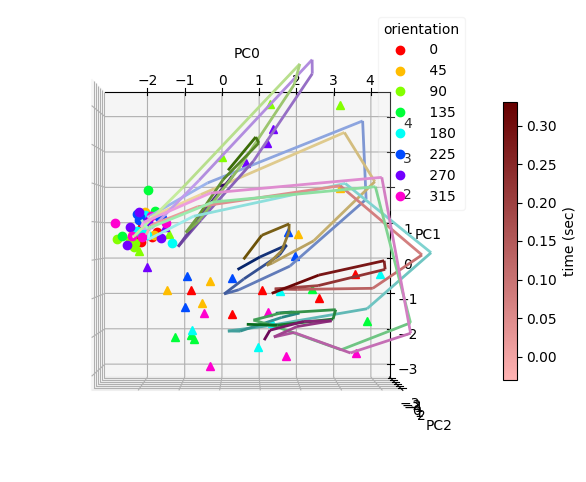

In [12]:
# %matplotlib notebook

PC_axis = [0, 1, 2]
pop_vec_cond_pc = pop_vec_cond.sel(PC=PC_axis, time_relative_to_stimulus_onset=slice(-0.05, 0.33))
t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values
ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
for i, orient in enumerate(pop_vec_cond_pc.orientation):
    clr = cmap1[i]
    pop_vec_orient = pop_vec_cond_pc.sel(orientation=orient)
    pop_vec_tfreq = pop_vec_orient.mean(dim='temporal_frequency')
    lighten_cmap = get_lighten_cmap(clr, light_scale=0.7, dark_scale=0.6)
    line = plot_multicolor_line(*pop_vec_tfreq, c=t, ax=ax, cmap=lighten_cmap, linewidth=2)
    ax.plot(*pop_vec_orient[:, :, 0], linestyle='none', marker='o',
            markersize=6, markeredgecolor=clr, markerfacecolor=clr, label=f'{orient: .0f}')
    ax.plot(*pop_vec_orient[:, :, -1], linestyle='none', marker='^',
            markersize=6, markeredgecolor=clr, markerfacecolor=clr)
    if not i:
        plt.colorbar(mappable=line, ax=ax, label='time (sec)', shrink=0.6)
ax.set_xlabel(f'PC{PC_axis[0]:d}')
ax.set_ylabel(f'PC{PC_axis[1]:d}')
ax.set_zlabel(f'PC{PC_axis[2]:d}')
ax.legend(loc='upper right', title='orientation', framealpha=0.2)
ax.view_init(90, -90) # xy
# ax.view_init(0, -90) # xz
# ax.view_init(0, 0) # yz

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))
plt.show()

In [13]:
n_top_pc = 3
PC_axis = np.arange(n_top_pc)
units_pc = np.sum(pca.components_[PC_axis] ** 2, axis=0) ** 0.5

pca_df = pd.DataFrame(
    {
        'mean_firing_rate': units_fr.units_mean_fr,
        'projection_on_top_PCs': units_pc,
        **{f'PC_{p:d}_component': pca.components_[p] for p in PC_axis}
    },
    index = pd.Index(units_fr.unit_id, name='unit_id')
)

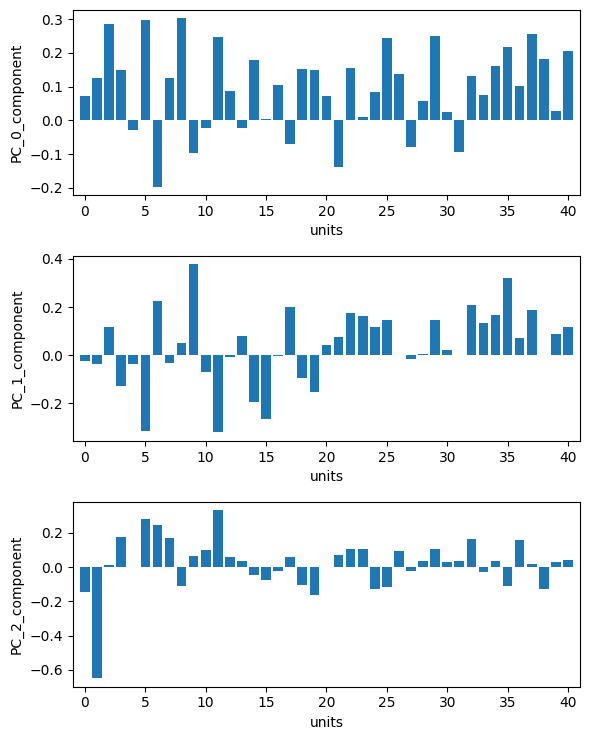

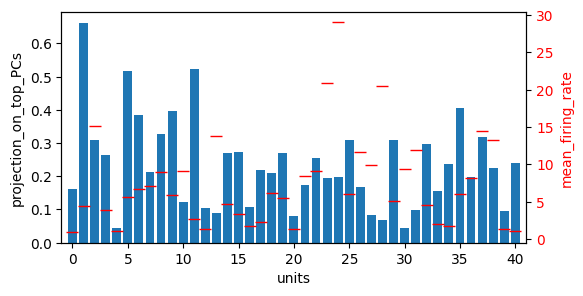

In [14]:
_, axs = plt.subplots(n_top_pc, 1, figsize=(6, 2.5 * n_top_pc))
for i in range(n_top_pc):
    ax = axs[i]
    label = f'PC_{PC_axis[i]:d}_component'
    ax.bar(range(n_units), pca_df[label])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel(label)
plt.tight_layout()

_, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(n_units), pca_df['projection_on_top_PCs'])
ax.set_xlim(-1, n_units)
ax.set_xlabel('units')
ax.set_ylabel('projection_on_top_PCs')
ax2 = ax.twinx()
ax2.plot(range(n_units), pca_df['mean_firing_rate'], color='r', linestyle='none', marker='_', markersize=8)
ax2.set_ylabel('mean_firing_rate', color='r')
ax2.tick_params(axis ='y', labelcolor='r')

plt.show()

#### Clustering end locations of orientations

In [35]:
temp_freq_idx = slice(4)
# temp_freq_idx = eval(input('Selected indices of temporal frequencies: '))
PC_axis = [0, 1, 2]
sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]
print('Selected conditions:')
print(sel_tfreq.to_series().to_string(index=False))

orient_pop_direction = pop_vec_cond.sel(
    PC=PC_axis, temporal_frequency=sel_tfreq, time_relative_to_stimulus_onset=slice(0.3, 2.0)
).mean(dim=['temporal_frequency', 'time_relative_to_stimulus_onset'])

Selected conditions:
temporal_frequency
1.0
2.0
4.0
8.0


In [16]:
from sklearn.cluster import KMeans

n_clusters = 3
# n_clusters = int(input("Number of clusters: "))

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
orient_labels = kmeans.fit_predict(orient_pop_direction.values.T)
orient_pop_centers = kmeans.cluster_centers_ @ pca.components_[PC_axis]

orientation_group_df = pd.DataFrame(dict(
    orientation={g: orient_pop_direction.orientation[orient_labels == g].values.tolist() for g in range(n_clusters)},
    **{f'PC_{p:d}_component': kmeans.cluster_centers_[:, p] for p in PC_axis},
    **{'distance': np.sum(kmeans.cluster_centers_ ** 2, axis=1) ** 0.5}
), index=pd.Index(range(n_clusters), name='orienation_group_id'))
pca_df = pca_df.assign(**{f'orientation_group_{g:d}': orient_pop_centers[g] for g in range(n_clusters)})
display(orientation_group_df)
# display(pca_df)

,orientation,PC_0_component,PC_1_component,PC_2_component,distance
orienation_group_id,,,,,
0,"[0.0, 135.0, 180.0, 315.0]",1.056191,-1.179521,0.909749,1.826048
1,"[45.0, 225.0]",0.842228,0.119086,-2.600220,2.735813
2,"[90.0, 270.0]",-0.301171,1.684091,-0.043520,1.711362


Time interval: (300.0, 1980.0) ms


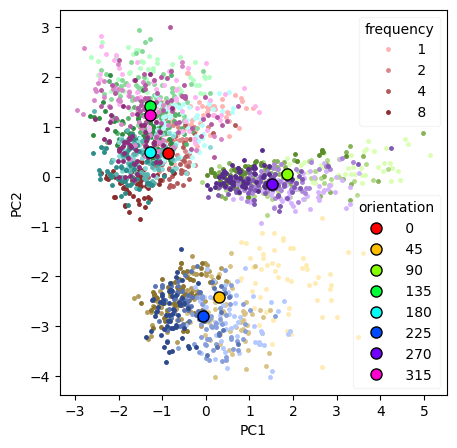

In [17]:
PC_axis = [1, 2]

ts = np.linspace(0, 1, n_tfreq)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
objs_leg = []
for i, orient in enumerate(pop_vec_cond.orientation):
    pop_vec_orient = pop_vec_cond.sel(PC=PC_axis, orientation=orient, time_relative_to_stimulus_onset=slice(0.3, 2.0))
    for j, tfreq in enumerate(sel_tfreq):
        clr = lighten(ts[j], cmap1[i])
        pop_vec_tfreq = pop_vec_orient.sel(temporal_frequency=tfreq)
        line = ax.plot(*pop_vec_tfreq, color=clr, linestyle='none', marker='.', markersize=5)
        if not i:
            line[0].set_label(f'{tfreq: .0f}')
            objs_leg.append(line[0])
    ax.set_xlabel(f'PC{PC_axis[0]:d}')
    ax.set_ylabel(f'PC{PC_axis[1]:d}')
leg1 = plt.legend(handles=objs_leg, title='frequency', loc='upper right', framealpha=0.2)
objs_leg = []
for i, orient in enumerate(pop_vec_cond.orientation):
    line = ax.plot(*orient_pop_direction.sel(PC=PC_axis, orientation=orient), color=cmap1[i],
                   linestyle='none', marker='o', markersize=8, markeredgecolor='k', label=f'{orient: .0f}')
    objs_leg.append(line[0])
ax.legend(handles=objs_leg, loc='lower right', title='orientation', framealpha=0.2)
ax.add_artist(leg1)

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))
plt.show()

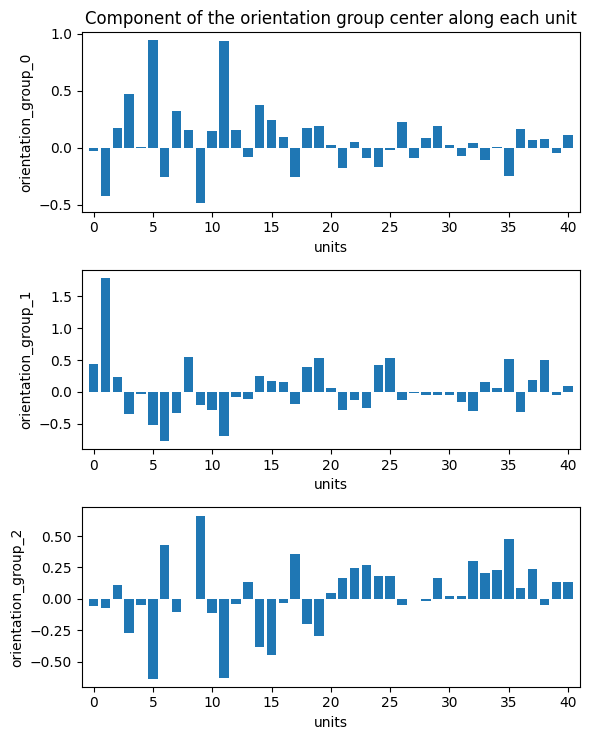

In [18]:
orientation_groups = np.array([s for s in pca_df.columns if 'orientation_group' in s])

_, axs = plt.subplots(n_clusters, 1, figsize=(6, 2.5 * n_clusters))
for i in range(n_clusters):
    ax = axs[i]
    ax.bar(range(n_units), pca_df[orientation_groups[i]])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel(orientation_groups[i])
axs[0].set_title('Component of the orientation group center along each unit')
plt.tight_layout()
plt.show()

### Save data for later analysis

In [19]:
filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

pop_vec_ds = pop_vec_cond.to_dataset(name='pop_vec', promote_attrs=True)
pop_vec_ds.to_netcdf(filepath_prefix + '_pop_vec.nc')
pca_df.to_csv(filepath_prefix + '_units_pca.csv')
orientation_group_df.to_csv(filepath_prefix + '_pca_orient_groups.csv')